In [1]:
# Uncomment the commented-out lines in this cell when generating ELMo embeddings to avoid excess warning messages, if problematic
import gc
import glob
import functools
import operator
import itertools
from sacremoses import MosesTokenizer  # For ELMo preprocessing
import matplotlib.pyplot as plt
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
# tf.logging.set_verbosity(tf.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow_hub as hub
from tensorflow.contrib import rnn
from IPython.display import clear_output
from tensorflow.layers import batch_normalization as bnorm
from tensorflow.nn import dropout, relu, leaky_relu
from Models import *

In [2]:
fs = glob.glob(data_dir + wiki_dir + "*.jsonl")
elmo_tokenizer = MosesTokenizer()  # Tokenise in the same way as ELMo's original training
transl_elmo = lambda s: ' '.join(elmo_tokenizer.tokenize(s, escape=False)).replace(" ' s ", " 's ").replace("-LSB-", "["). \
    replace("-RSB-", "]")

In [3]:
transl_elmo("From 1985―2015 Coster-Waldau"), transl_elmo("From 1985-2015 Coster-Waldau -RSB- -LSB-")  # Leaves the dashes alone

('From 1985 ― 2015 Coster-Waldau', 'From 1985-2015 Coster-Waldau ] [')

In [90]:
# Load labelled training+dev claims, their sentences and their label
claims, claims_vocab = load_claims(n=np.inf, test_10=False)      # Load all training claims
claims_dev, claims_vocab_dev = load_claims(n=np.inf, dev=True)   # Load all development claims
claims_fin, claims_vocab_fin = load_claims(n=np.inf, test=True)
fin_evi_A, fin_probs_A, fin_preds_A = load_ld("final_test_relevance_predictions_A.data", pad=False)
fin_evi_B, fin_probs_B, fin_preds_B = load_ld("final_test_relevance_predictions_B.data", pad=False)
fin_evi, fin_probs, fin_preds = fin_evi_A + fin_evi_B, fin_probs_A + fin_probs_B, fin_preds_A + fin_preds_B
claims_finn, claims_vocab_finn, finn_idx = [], set(), []
for i in range(len(claims_fin)):                             # finn = Final predictions for neural network
    if fin_preds[i]:
        claim = claims_fin[i]
        finn_idx.append(i)
        claim["evidence"] = [[([-1, -1] + list(e)) for e in fin_evi[i]]]
        claims_finn.append(claim)
        claims_vocab_finn |= set(claim["vocab"].keys())
N_claims_train, N_claims_test, N_claims_fin = len(claims), len(claims_dev), len(claims_finn)
claims += claims_dev
claims_vocab |= claims_vocab_dev
claims += claims_finn
claims_vocab |= claims_vocab_finn
N_claims = len(claims)
print(N_claims, ',', len(claims_vocab), ',', N_claims_train, N_claims_test, N_claims_fin)

134966 , 27707 , 109800 13332 11834


In [5]:
wiki_lines = load_docs_lines()  # Same as in question 4 (reload from file using cell below)

109 / 109

In [81]:
# save_ld(wiki_lines, "loaded_wikilines")
wiki_lines = load_ld("loaded_wikilines")
len(wiki_lines)

5396106

In [82]:
X_claims, X_evidences, Y, n_train, n_test, n_fin = [], [], [], 0, 0, 0
for c_i in range(len(claims)):
    train_ = c_i < N_claims_train
    test_ = (not train_) and (c_i < N_claims_train + N_claims_test)
    claim = claims[c_i]
    claim_str = transl_elmo(claim["claim"])
    for eva_set in claim["evidence"]:
        X_claims.append(claim_str)
        X_evidences.append(' '.join([transl_elmo(wiki_lines[eva[2]][eva[3]]) for eva in eva_set]))
        Y.append(claim['label'] == 'SUPPORTS' if 'label' in claim else False)
        if train_: n_train += 1
        elif test_: n_test += 1
        else:        n_fin += 1
X_claims = np.asarray(X_claims)
X_evidences = np.asarray(X_evidences)
Y = np.asarray(Y)

In [79]:
del wiki_lines
gc.collect()

8

In [83]:
save_ld((X_claims, X_evidences, Y, n_train), "nn_data")
# X_claims, X_evidences, Y, n_train = load_ld("nn_data")

In [89]:
X_claims_sl = np.asarray([len(x.split(' ')) for x in X_claims])
X_evidences_sl = np.asarray([len(x.split(' ')) for x in X_evidences])
X_claims_train, X_claims_test, X_claims_fin = X_claims[:n_train], X_claims[n_train:-n_fin], X_claims[-n_fin:]
X_claims_sl_train, X_claims_sl_test, X_claims_sl_fin = X_claims_sl[:n_train], X_claims_sl[n_train:-n_fin], X_claims_sl[-n_fin:]
X_evidences_train, X_evidences_test, X_evidences_fin = X_evidences[:n_train], X_evidences[n_train:-n_fin], X_evidences[-n_fin:]
X_evidences_sl_train, X_evidences_sl_test, X_evidences_sl_fin = \
    X_evidences_sl[:n_train], X_evidences_sl[n_train:-n_fin], X_evidences_sl[-n_fin:]
Y__ = np.atleast_2d(Y)
Y_ = np.zeros((Y__.size, 2))
Y_[np.arange(Y__.size), (Y__).astype(np.int)] = 1
Y_train, Y_test, Y_fin = Y_[:n_train], Y_[n_train:-n_fin], Y_[-n_fin:]
n_train, n_test, n_fin, Y_.shape, np.sum(Y[:n_train]) / len(Y[:n_train]), np.sum(Y[n_train:-n_fin]) / len(Y[n_train:-n_fin])

(221460, 24725, 11834, (258019, 2), 0.7280502122279419, 0.5054802831142569)

In [7]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)  # Load ELMo

# just a random sentence 
x = ["The quick brown fox",
     "The quick brown fox jumped",
     "The quick brown fox jumped over",
     "Random test sentence without any relevance",
     "The quick brown fox jumped over the lazy dog",]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
embeddings.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TensorShape([Dimension(5), Dimension(9), Dimension(1024)])

In [8]:
def elmo_vectors(x, key='elmo'):
    embeddings = elmo(x, signature="default", as_dict=True)[key]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)
v = elmo_vectors(x, key='elmo')          # Test ELMo
v_ = elmo_vectors(x)
w = elmo_vectors(x, key='default')
# "default" 1024-d sentence embedding is mean-pooling of contextualised word vectors, excluding the stop word
v.shape, w.shape, sum(np.mean(v[-1], axis=0) - w[-1]), sum(np.mean(v[-2], axis=0) - w[-2]), np.sum(v_ - v)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


((5, 9, 1024),
 (5, 1024),
 5.418332875706255e-07,
 1.4267737744376063,
 -2.1007145e-07)

In [9]:
v_[-4:, 4:, 0] # An identical stop symbol is used at the end of all sentences with length lower than the max; use indexing

array([[ 0.05095774, -0.02840838, -0.02840838, -0.02840838, -0.02840838],
       [ 0.05095774, -0.45303297, -0.02840838, -0.02840838, -0.02840838],
       [-0.13401808, -0.26723588, -0.02840838, -0.02840838, -0.02840838],
       [ 0.05095774, -0.45303297, -0.26147586, -0.31868368,  0.26189953]],
      dtype=float32)

In [48]:
   ###   Options   ###

# model_name = "flat_model"             # First, use a mean pooling of the claim and chained evidence
# model_name = "rnn_model"              # Second, use an LSTM on each of the claim and chained evidence, and concatenate
# model_name = "attention_model"        # Third, use the claim as an attention query over the chained evidence (the key & value)
model_name = "attention_doublehead"
# train_set_test_frac = 0.0005   
train_set_test_frac = 0.01
# train_set_test_frac = 0.1             # Get training accuracy for random 10% subset of training set
log_period_batches = 200                # Number of batches between performance evaluations and graph replots
n_epochs = 1000
learning_rate = 3.14e-6 if model_name == "rnn_model" else 1e-5
dropout_keep_prob = 0.85
dropout_rnn = 0.67
batch_size = 16 #64
lstm_forget_bias = 1.0
rnn_stack_n = 1
c_type = "LSTM" # "Vanilla", "GRU"

inp_c_units = 1024      # Claim word units
inp_e_units = 1024      # Evidence word units
n_rnn_units = 1024      # RNN units
l1_units = 1024
l2_units = 1024

In [50]:
# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xc = X_claims_train[batch_idx]
    xe = X_evidences_train[batch_idx]
    xc_sl = X_claims_sl_train[batch_idx]
    xe_sl = X_evidences_sl_train[batch_idx]
    y  = Y_train[batch_idx]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xc, xe, xc_sl, xe_sl, y

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

xc = tf.placeholder(tf.string, [None], name='xclaims')
xe = tf.placeholder(tf.string, [None], name='xevi')
xc_sl = tf.placeholder(tf.int32, [None], name='xclaims_seqlen')
xe_sl = tf.placeholder(tf.int32, [None], name='xevi_seqlen')
y  = tf.placeholder(tf.float32, [None, 2], name="ylabel")
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)
#     return bnorm(inp)

elmo_units = 1024
inp_c_W = tf.Variable(izer([elmo_units, inp_c_units]), name='xc_inp_W')
inp_c_b = tf.Variable(izer([inp_c_units]), name='xc_inp_b')
inp_e_W = tf.Variable(izer([elmo_units, inp_e_units]), name='xe_inp_W')
inp_e_b = tf.Variable(izer([inp_e_units]), name='xe_inp_b')
l1_b = tf.Variable(izer([l1_units]), name='l1_b')
l2_W = tf.Variable(izer([l1_units, l2_units]), name='l2_W')
l2_b = tf.Variable(izer([l2_units]), name='l2_b')
out_W = tf.Variable(izer([l2_units, 2]), name='out_W')
out_b = tf.Variable(izer([2]), name='out_b')

elmo_xc = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
elmo_xe = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
xc_emb = elmo_xc(xc, signature="default", as_dict=True)['elmo']  # (bsize, max_seqlen, 1024)
xe_emb = elmo_xe(xe, signature="default", as_dict=True)['elmo']
bsize, max_seqlen, max_claimlen = tf.shape(xc)[0], tf.shape(xe_emb)[1], tf.shape(xc_emb)[1]

def get_rnn_cell(c_type, lstm_forget_bias, kp, **ps):
  cell = rnn.GRUCell(n_rnn_units, **ps) if c_type == "GRU" else \
        (rnn.BasicRNNCell(n_rnn_units, **ps) if c_type == "Vanilla" else \
         rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, **ps))
  return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)

l1_W, l1 = None, None
if model_name.split('_')[0] == 'flat':                                                                               # Flat
    l1_W = tf.Variable(izer([inp_c_units + inp_e_units, l1_units]), name='l1_W')
    xc_l0 = tf.reshape(tf.matmul(tf.reshape(xc_emb, [-1, elmo_units]), inp_c_W) + inp_c_b, [bsize, -1, inp_c_units])
    xe_l0 = tf.reshape(tf.matmul(tf.reshape(xe_emb, [-1, elmo_units]), inp_e_W) + inp_e_b, [bsize, -1, inp_e_units])
    xc_l1 = tf.gather_nd(tf.cumsum(xc_l0, axis=1), tf.stack([tf.range(bsize), xc_sl - 1], axis=1)) / \
        tf.expand_dims(tf.cast(xc_sl, tf.float32), 1)
    xe_l1 = tf.gather_nd(tf.cumsum(xe_l0, axis=1), tf.stack([tf.range(bsize), xe_sl - 1], axis=1)) / \
        tf.expand_dims(tf.cast(xe_sl, tf.float32), 1)
    l1 = bnorm_appl(leaky_relu(tf.matmul(tf.concat([xc_l1, xe_l1], axis=1), l1_W) + l1_b))
    
elif model_name.split('_')[0] == 'rnn':                                                                              # RNN 
    l1_W = tf.Variable(izer([2 * n_rnn_units, l1_units]), name='l1_W')
    xc_cell, xe_cell = None, None
    
    if rnn_stack_n > 1:
        xc_cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(rnn_stack_n)])
        xe_cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(rnn_stack_n)])
    else:
        xc_cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp, name='xc_rnn')
        xe_cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp, name='xe_rnn')
    # xc_emb = tf.reshape(tf.matmul(tf.reshape(xc_emb, [-1, elmo_units]), inp_c_W) + inp_c_b, [bsize, -1, inp_c_units])
    # xe_emb = tf.reshape(tf.matmul(tf.reshape(xe_emb, [-1, elmo_units]), inp_e_W) + inp_e_b, [bsize, -1, inp_e_units])
    xc_rnn, xc_rnn_states = tf.nn.dynamic_rnn(xc_cell, xc_emb, sequence_length=xc_sl, dtype=tf.float32)
    xc_rnn = tf.gather_nd(xc_rnn, tf.stack([tf.range(bsize), xc_sl - 1], axis=1))
    xe_rnn, xe_rnn_states = tf.nn.dynamic_rnn(xe_cell, xe_emb, sequence_length=xe_sl, dtype=tf.float32)
    xe_rnn = tf.gather_nd(xe_rnn, tf.stack([tf.range(bsize), xe_sl - 1], axis=1))
    l1 = bnorm_appl(leaky_relu(tf.matmul(tf.concat([xc_rnn, xe_rnn], axis=1), l1_W) + l1_b))

elif model_name.split('_')[0] == 'attention':                                                                        # Attention
#     l1_W = tf.Variable(izer([n_rnn_units, l1_units]), name='l1_W')
    l1_W = tf.Variable(izer([n_rnn_units * 2, l1_units]), name='l1_W')
    inp_c_W2 = tf.Variable(izer([elmo_units, inp_c_units]), name='xc_inp_W')
    inp_c_b2 = tf.Variable(izer([inp_c_units]), name='xc_inp_b')
    inp_e_W2 = tf.Variable(izer([elmo_units, inp_e_units]), name='xe_inp_W')
    inp_e_b2 = tf.Variable(izer([inp_e_units]), name='xe_inp_b')
    # inp_c_W = tf.Variable(izer([elmo_units, n_rnn_units]), name='xc_inp_W')  # If not projecting prior to attention (worse)
    # inp_c_b = tf.Variable(izer([n_rnn_units]), name='xc_inp_b')
    x_cell, x_cell2 = None, None
    def get_rnn_cell(c_type, lstm_forget_bias, kp, **ps):
      cell = rnn.GRUCell(n_rnn_units, **ps) if c_type == "GRU" else \
            (rnn.BasicRNNCell(n_rnn_units, **ps) if c_type == "Vanilla" else \
             rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, **ps))
      return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
    if rnn_stack_n > 1:
        x_cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(rnn_stack_n)])
        x_cell2 = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(rnn_stack_n)])
    else:
        x_cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp, name='x_rnn')
        x_cell2 = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp, name='x_rnn2')
    # Project individual contextual word embeddings prior to dot product (optimising for the fact checking objective)
    xc_emb  = tf.reshape(tf.matmul(tf.reshape(xc_emb, [-1, elmo_units]), inp_c_W)  + inp_c_b,  [bsize, -1, inp_c_units])
    xc_emb2 = tf.reshape(tf.matmul(tf.reshape(xc_emb, [-1, elmo_units]), inp_c_W2) + inp_c_b2, [bsize, -1, inp_c_units])
    xe_emb  = tf.reshape(tf.matmul(tf.reshape(xe_emb, [-1, elmo_units]), inp_e_W)  + inp_e_b,  [bsize, -1, inp_e_units])
    xe_emb2 = tf.reshape(tf.matmul(tf.reshape(xe_emb, [-1, elmo_units]), inp_e_W2) + inp_e_b2, [bsize, -1, inp_e_units])
    atten_scores = tf.matmul(xc_emb, xe_emb, transpose_b=True)
    atten_scores2 = tf.matmul(xc_emb, xe_emb2, transpose_b=True)
    mask = tf.transpose(tf.reshape(tf.tile(tf.transpose(tf.sequence_mask(xe_sl, maxlen=max_seqlen, \
                    dtype=tf.dtypes.float32), [1, 0]), [max_claimlen, 1]), [max_claimlen, max_seqlen, bsize]), [2, 0, 1])
    atten_scores *= mask
    atten_scores2 *= mask
    atten_dist = tf.nn.softmax(atten_scores)
    atten_dist2 = tf.nn.softmax(atten_scores2)
    atten_output = tf.matmul(atten_dist, xe_emb)
    atten_output2 = tf.matmul(atten_dist2, xe_emb2)
    # atten_output *= tf.sequence_mask(xc_sl, maxlen=max_claimlen)  # If we want to take the mean pooling
        # If not projecting prior to attention
    # atten_output = tf.reshape(tf.matmul(tf.reshape(atten_output, [-1, elmo_units]), inp_c_W)+inp_c_b, [bsize,-1,n_rnn_units])
    x_rnn, x_rnn_states = tf.nn.dynamic_rnn(x_cell, atten_output, sequence_length=xc_sl, dtype=tf.float32)
    x_rnn2, x_rnn_states2 = tf.nn.dynamic_rnn(x_cell2, atten_output2, sequence_length=xc_sl, dtype=tf.float32)
    x_rnn = tf.gather_nd(x_rnn, tf.stack([tf.range(bsize), xc_sl - 1], axis=1))
    x_rnn2 = tf.gather_nd(x_rnn2, tf.stack([tf.range(bsize), xc_sl - 1], axis=1))
#     l1 = bnorm_appl(leaky_relu(tf.matmul(x_rnn, l1_W) + l1_b))
    l1 = bnorm_appl(leaky_relu(tf.matmul(tf.concat([x_rnn, x_rnn2], axis=1), l1_W) + l1_b))

l2 = tf.matmul(l1, l2_W) + l2_b
lout = leaky_relu(tf.matmul(l2, out_W) + out_b)
# y_hat = tf.nn.softmax(lout)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=lout))

# train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# train_step = tf.train.RMSPropOptimizer(0.1).minimize(loss)
# train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
correct = tf.cast(tf.equal(tf.argmax(lout, axis=1), tf.argmax(y, axis=1)), tf.float32)
accuracy = tf.reduce_mean(correct)

# Train
batch_i = 0
best_acc = 0
best_val_acc = 0
best_acc_idx = 0
best_acc_tr = 0
best_preds = None
saver = tf.train.Saver()
create_folder("models")
create_folder("model_logs")
create_folder("models/" + model_name)
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [51]:
n_total_batches = ((n_epochs + 1) * n_train) // batch_size
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Epoch 3 : 0.9345076784101165 0.7653846153846146 (0) loss: 0.17465643538288314 0.5674540672451258 Best: 0.8992773260527503 0.7971153846153838 (0.7971153846153838) 128


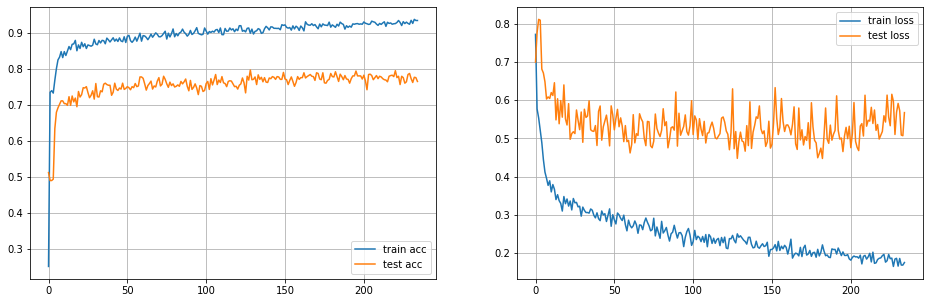

Batch 47001 (752016 samples) complete

KeyboardInterrupt: 

In [52]:
train_iteration()

Epoch 6 : 0.9426377596570864 0.7644230769230762 (0) loss: 0.14860644884064272 0.5812077171240864 Best: 0.9345076784639601 0.7923076923076915 (0.7923076923076915) 376


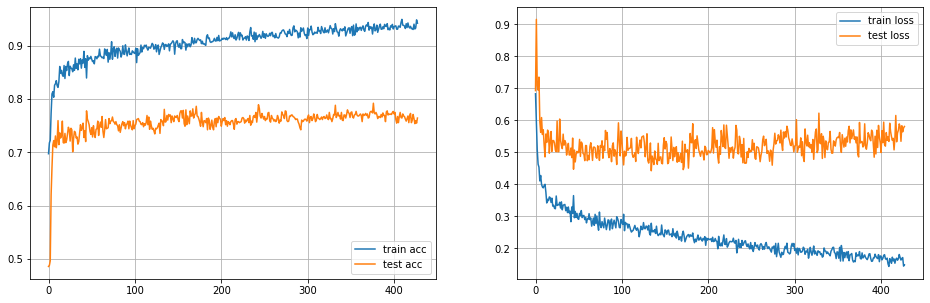

Batch 85601 (1369616 samples) complete

KeyboardInterrupt: 

In [46]:
train_iteration()

Epoch 1 : 0.8780487804878043 0.7288461538461533 (0) loss: 0.3104649932403875 0.5162651689006732 Best: 0.8798554652213183 0.7644230769230762 (0.7644230769230762) 83


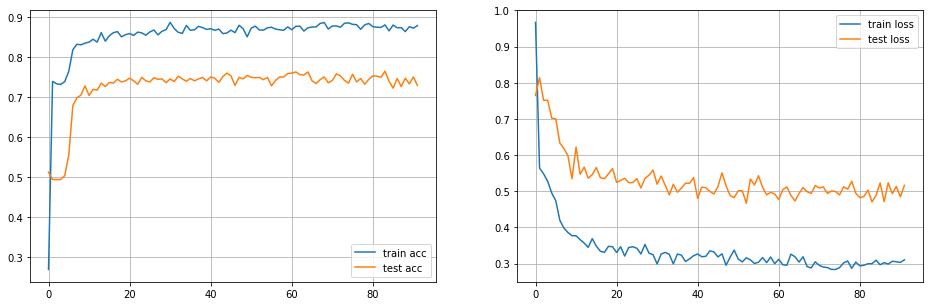

Batch 18401 (294416 samples) complete

KeyboardInterrupt: 

In [38]:
train_iteration()

In [47]:
sess.close()

In [45]:
def train_iteration(es=np.inf, verbose=True):
    global batch_i, n_total_batches, train_loss, test_loss, train_accuracy, test_accuracy, best_acc, best_val_acc, \
        best_acc_tr, best_acc_idx, \
        best_preds, log_period_batches, batch_size

    b_no_inp = 0
    while batch_i < n_total_batches and b_no_inp < es:  # Stop when we reach max. batches or early stopping criterion
    # while epochs_completed < n_epochs:

        batch_i += 1
        batch_xcs, batch_xes, batch_xc_sls, batch_xe_sls, batch_ys = next_batch(batch_size)
        sess.run([train_step], feed_dict={xc: batch_xcs, xe: batch_xes, xc_sl: batch_xc_sls, xe_sl: batch_xe_sls, y: batch_ys,
              rnn_kp: dropout_rnn, keep_prob: dropout_keep_prob})
        if verbose:
            sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if (batch_i - 1) % log_period_batches == 0:
            bsz = 16
            n_test_actual = 1024
            indices = np.random.choice(n_train, n_train_test, replace=False)
            feed_batches = [indices[i * bsz:(i + 1) * bsz] for i in range((n_train_test // bsz) + 1)]
            train_l, train_a = zip(*[sess.run([loss, accuracy], feed_dict={
                   xc: X_claims_train[inds],       xe: X_evidences_train[inds], 
                xc_sl: X_claims_sl_train[inds], xe_sl: X_evidences_sl_train[inds],  y: Y_train[inds],
                rnn_kp: 1.0, keep_prob: 1.0}) for inds in feed_batches])
            inds_ws = np.asarray([len(inds) for inds in feed_batches]).astype(float)
            inds_ws /= sum(inds_ws)
            train_l, train_a = sum(inds_ws * train_l), sum(inds_ws * train_a)

#             indices = np.random.choice(n_test, n_test_actual, replace=False)
#             feed_batches = [indices[i * bsz:(i + 1) * bsz] for i in range((n_test_actual // bsz))]
            feed_batches = [range(n_test)[i * bsz:(i + 1) * bsz] for i in range((n_test_actual // bsz) + 1)]  # Keep fixed
            test_l, test_a = zip(*[sess.run([loss, accuracy], feed_dict={
                   xc: X_claims_test[inds],       xe: X_evidences_test[inds], 
                xc_sl: X_claims_sl_test[inds], xe_sl: X_evidences_sl_test[inds],  y: Y_test[inds],
#                    xc: X_claims_test[:64],       xe: X_evidences_test[:64],       # testing on low-capacity hardware
#                 xc_sl: X_claims_sl_test[:64], xe_sl: X_evidences_sl_test[:64],  y: Y_test[:64],
                rnn_kp: 1.0, keep_prob: 1.0}) for inds in feed_batches])
            inds_ws = np.asarray([len(inds) for inds in feed_batches]).astype(float)
            inds_ws /= sum(inds_ws)
            test_l, test_a = sum(inds_ws * test_l), sum(inds_ws * test_a)

            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            val_a = 0
#             if train_a > best_val_acc:
            if test_a > best_val_acc:      # Save best validation (development) set accuracy model
                best_acc = test_a
#                 best_val_acc = train_a
                best_val_acc = test_a
                best_acc_tr = train_a
                best_acc_idx = batch_i // log_period_batches
                saver.save(sess, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches

            if verbose:
                clear_output()
                print("Epoch", epochs_completed, ':', train_a, test_a, "(" + str(val_a) + ")", "loss:", train_l, test_l, \
                      "Best:", best_acc_tr, best_acc, "(" + str(best_val_acc) + ")", \
                      best_acc_idx)
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')
#                 g.axhline(y=0.714, ls='--', color='grey')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                g.plot(test_loss, label='test loss')
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        "model_logs/" + model_name + '_log_latest', pad=False)
                graphs_folder = "graphs"
                create_folder(graphs_folder)
                plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
                plt.show()
    return best_val_acc, best_acc
# Result format: (train accuracy, test accuracy), (training loss, testing loss), (best test acc accs)

In [58]:
sess.close()
sess = tf.Session()
saver.restore(sess, "./models/" + model_name + '/' + model_name)

INFO:tensorflow:Restoring parameters from ./models/attention_doublehead/attention_doublehead


INFO:tensorflow:Restoring parameters from ./models/attention_doublehead/attention_doublehead


In [59]:
bsz = 16  # Test accuracy of restored model
n_test_actual = 1024
feed_batches = [range(n_test)[i * bsz:(i + 1) * bsz] for i in range((n_test_actual // bsz) + 1)]  # Keep fixed
test_l, test_a = zip(*[sess.run([loss, accuracy], feed_dict={
       xc: X_claims_test[inds],       xe: X_evidences_test[inds], 
    xc_sl: X_claims_sl_test[inds], xe_sl: X_evidences_sl_test[inds],  y: Y_test[inds],
    rnn_kp: 1.0, keep_prob: 1.0}) for inds in feed_batches])
inds_ws = np.asarray([len(inds) for inds in feed_batches]).astype(float)
inds_ws /= sum(inds_ws)
test_l, test_a = sum(inds_ws * test_l), sum(inds_ws * test_a)
test_l, test_a

(0.4475276452990678, 0.7971153846153838)

In [96]:
y_hat = tf.nn.softmax(lout)
feed_batches = [range(n_fin)[i * bsz:(i + 1) * bsz] for i in range((n_fin // bsz) + 1)]  # Keep fixed
probs = [sess.run([y_hat], feed_dict={
       xc: X_claims_fin[inds],       xe: X_evidences_fin[inds], 
    xc_sl: X_claims_sl_fin[inds], xe_sl: X_evidences_sl_fin[inds],  y: Y_fin[inds],
    rnn_kp: 1.0, keep_prob: 1.0}) for inds in feed_batches]

In [102]:
probs = np.vstack([probs_[0] for probs_ in probs])
probs = probs[:, 1]
np.sum(probs > 0.5) / len(probs)

0.6743282068615852

In [103]:
save_ld(probs, "final_probs_nn.data", pad=False)

In [111]:
# Construct final predictions list
final_preds = []
for i in range(len(claims_fin)):
    claim = {'id': claims_fin[i]['id']}
    claim['predicted_label'] = 'NOT ENOUGH INFO'
    claim['predicted_evidence'] = fin_evi[i]
    if i in finn_idx: claim['predicted_label'] = ('SUPPORTS' if (probs[finn_idx.index(i)] > 0.5) else 'REFUTES')
    final_preds.append(claim)

In [117]:
len(final_preds), final_preds[0], final_preds[1], final_preds[-1]

(19998,
 {'id': 89296, 'predicted_label': 'NOT ENOUGH INFO', 'predicted_evidence': []},
 {'id': 78554,
  'predicted_label': 'REFUTES',
  'predicted_evidence': [('John_Ritter', 8)]},
 {'id': 51709,
  'predicted_label': 'SUPPORTS',
  'predicted_evidence': [("The_Handmaid's_Tale_-LRB-TV_series-RRB-", 5)]})

In [123]:
with jsonlines.open('predictions.jsonl', mode='w') as writer:
    [writer.write(l) for l in final_preds]

In [118]:
# Extrapolating from the predicted class distribution, the test set likely has the same class ratios as the training dist.
sum([c["predicted_label"] == 'SUPPORTS' for c in final_preds]) / len(final_preds), \
    sum([c["predicted_label"] == 'REFUTES' for c in final_preds]) / len(final_preds), \
    sum([c["predicted_label"] == 'NOT ENOUGH INFO' for c in final_preds]) / len(final_preds)

(0.399039903990399, 0.1927192719271927, 0.40824082408240825)

In [119]:
claims_trall, _ = load_claims(n=np.inf, test_10=False, verifiable_only=False)      # Load all training claims
claims_devall, _ = load_claims(n=np.inf, dev=True, verifiable_only=False)   # Load all development claims

In [120]:
sum([c["label"] == 'SUPPORTS' for c in claims_trall]) / len(claims_trall), \
    sum([c["label"] == 'REFUTES' for c in claims_trall]) / len(claims_trall), \
    sum([c["label"] == 'NOT ENOUGH INFO' for c in claims_trall]) / len(claims_trall)

(0.5502375566388658, 0.2047181292500636, 0.2450443141110706)

In [121]:
sum([c["label"] == 'SUPPORTS' for c in claims_devall]) / len(claims_devall), \
    sum([c["label"] == 'REFUTES' for c in claims_devall]) / len(claims_devall), \
    sum([c["label"] == 'NOT ENOUGH INFO' for c in claims_devall]) / len(claims_devall)

(0.3333333333333333, 0.3333333333333333, 0.3333333333333333)

In [ ]:
model_name = "flat_model"             # First, use a mean/max pooling of the claim and chained evidence
train_set_test_frac = 0.2  # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 25
learning_rate = 1e-4

# dropout_keep_prob = 0.67
# dropout_rnn = 0.55

batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU" # "Vanilla", "LSTM"

inp_c_units = 256
inp_e_units = 512

l1_units = 512
l2_units = 512
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 32
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    x_pastelos = X_pastelos_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, x_pastelos, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats, alpha=None, beta=None, gamma=None):
    with tf.name_scope("autolog"):
#         x_ = tf.clip_by_value(x, -4.5, 4.5)
        if alpha is None: alpha = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        if beta is None:  beta  = tf.Variable(np.tile(0.4, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        if gamma is None: gamma = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
#         alpha = tf.constant(0.1, name='autolog-alpha')
#         beta = tf.constant(0.4, name='autolog-beta')
#         gamma = tf.constant(0.1, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-8, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_" + r + "_rnn") for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="seq_len_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
x_pastelo = tf.placeholder(tf.float32, [None, N_PL], name="x_pastelos")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_labels") for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name=(Yr_use[i] if f2(Yr_use[i]) not in t_roles else \
        '_'.join(Yr_use[i].split('_')[2:] + [f2(Yr_use[i])])) + "_targets") for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

n_champions = len(champ_dict)
n_features = X_train.shape[1]

n_input_feats = n_features
# n_input_feats = n_features + (N_PL ** 2)
# n_input_feats = n_features + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)
#     return inp

xr_alphas = [tf.Variable(np.tile(ra, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_alphas = [tf.Variable(np.tile(0.02, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
xr_betas = [tf.Variable(np.tile(rb, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_betas = [tf.Variable(np.tile(0.15, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
xr_gammas = [tf.Variable(np.tile(rg, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_gammas = [tf.Variable(np.tile(0.12, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_alphas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_betas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.4, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_gammas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# x_alpha = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)
# x_beta = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.4, n_features).astype(np.float32), trainable=True)
# x_gamma = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)

tf_true =  tf.constant(True, dtype=tf.bool)
tf_false =  tf.constant(False, dtype=tf.bool)
global_pars = {"is_train": tf_false}

with tf.name_scope("metadata"):
#     b_size = tf.shape(x)[0]
    x_reg = tf.gather(x, X_reg_idx, axis=1)

with tf.name_scope("past_games"):
#     xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
    xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), \
                  Xr_mins[i % 5], n_rec_features, xr_alphas[i % 5], xr_betas[i % 5], xr_gammas[i % 5]) for i in N_PL_r]
with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                (rnn.BasicRNNCell(n_rnn_units, name="rnn_cell") if c_type == "Vanilla" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell"))
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)

        with tf.name_scope("rnn_beginToken_W"):
#             W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_reg_idx) + 1, n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        x_token = [tf.concat([x_reg, tf.gather(x_pastelo, [i], axis=1)], axis=1) for i in N_PL_r]
        init_states = [tf.matmul(x_token[i], W_begin_token[i % 5]) + b_begin_token[i % 5] for i in N_PL_r]
#         init_states = [tf.tile(W_begin_token[i], [tf.shape(xrsl[0])[0], 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, 1]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r
#         ones = tf.ones((tf.shape(x)[0], 1))
#         zeros = tf.zeros((tf.shape(x)[0], 1))

        post_rnn = [tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5] for i in N_PL_r]
#         post_rnn = [tf.matmul(leaky_relu(rnn_outs[i]), Xr_W1s[i % 5]) + Xr_b1s[i] for i in N_PL_r]
#         post_rnn_layers = [post_rnn[i] for i in N_PL_r]
#         post_rnn_layers = [bnorm_appl(post_rnn[i]) for i in N_PL_r]
        post_rnn_layers = [bnorm(post_rnn[i]) for i in N_PL_r]
#         post_rnn_layers = [bnorm_appl(tf.matmul(post_rnn[i], Xr_W2s[i % 5])) for i in N_PL_r]
#         post_rnn_layers = [bnorm_appl(leaky_relu(post_rnn[i])) for i in N_PL_r]
#         rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join
#         rnn_l1 = [bnorm_appl(tf.matmul(tf.concat([post_rnn_layers[i], zeros if i >= 5 else ones], axis=1),
#                                        Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

#         pca_comps = 2
#         pcas = [PCA_Layer(pca_comps, 1, batch_size=tf.shape(post_rnn[0])[0]) for _ in roles_all]
#         post_rnn_layers = [pcas[i % 5].feedforward(bnorm(post_rnn[i]), global_pars) for i in N_PL_r]

#     with tf.name_scope("post_rnn_fc"):
#         Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
#         post_rnn_lin = [leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5]) for i in N_PL_r]

# with tf.name_scope("flat_mods"):
#     Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
#     # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

#     post_rnn_layers = [bnorm_appl(post_rnn_lin[i]) for i in N_PL_r]
#     rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("flat_mods"):
    x_alpha = tf.Variable(np.tile(a, n_features).astype(np.float32), trainable=True)
#     x_alpha = tf.Variable(np.tile(0.02, n_features).astype(np.float32), trainable=True)
    x_beta = tf.Variable(np.tile(b, n_features).astype(np.float32), trainable=True)
#     x_beta = tf.Variable(np.tile(0.35, n_features).astype(np.float32), trainable=True)
    x_gamma = tf.Variable(np.tile(g, n_features).astype(np.float32), trainable=True)
#     x_gamma = tf.Variable(np.tile(0.02, n_features).astype(np.float32), trainable=True)
    
    with tf.name_scope("team_compositions"):
        # Add champion compositions and pick positions
        x_champsum = tf.one_hot(x_chmp, n_champions)
        x_pposes = tf.one_hot(x_ppos, N_PL)
        x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
        x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
        x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
        x_input = autolog(x, X_mins, n_features, x_alpha, x_beta, x_gamma)
#         x_input = tf.concat([autolog(x, X_mins, n_features, x_alpha, x_beta, x_gamma),
#                              x_ch_bsum,
#                              x_ch_rsum,
#                              tf.reshape(x_pposes, [-1, N_PL ** 2]),
#                              tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)
#                              tf.reshape(x_pposes, [-1, N_PL ** 2])], axis=1)

    with tf.name_scope("fully_connected"):
        Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

#         W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        W_1 = tf.Variable(izer([n_input_feats + (post_rnn_units * N_PL), l1_n_units]))
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

#     #     relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1)
#         relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
# #         relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

#         relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
#         relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
#         relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
#         # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
#         # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
#         # drop_out = dropout(relu_2, keep_prob)
#         # y_out = tf.matmul(drop_out, W_3) + b_3
#         # y_out = tf.matmul(relu_3, W_4) + b_4
#         #   y_prob = tf.nn.softmax(y_out)
        
#         relu_4 = x_input
        relu_4 = tf.concat([x_input] + post_rnn_layers, axis=1)
#         relu_4 = tf.matmul(tf.concat([x_input] + post_rnn_layers, axis=1), W_1) + b_1
#         l4_n_units = n_input_feats
        l4_n_units = n_input_feats + (post_rnn_units * N_PL)
#         l4_n_units = n_input_feats + (1 * N_PL)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

    # Define loss function & training step
    Yc_outprobs = [tf.nn.softmax(Yc_outs[i]) for i in range(len(Yc_targets))]
    with tf.name_scope("loss"):
        with tf.name_scope("classif_xent_loss"):
            Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                         labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_l2_losses"):
            Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    #         loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
        loss = sum(Yc_losses)
#         if regr_loss_ratio > 0: loss += (regr_loss_ratio * tf.reduce_mean(Yr_losses))

    with tf.name_scope("train"):
#         flat_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "flat_mods")
#         train_step = AMSGrad(learning_rate=learning_rate_amsgrad,
#                                 beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss, var_list=flat_trainables)
#         train_step = tf.train.RMSPropOptimizer(0.1).minimize(loss)
#         train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
    #     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

    with tf.name_scope("accuracy"):
        # Define accuracy computation
        correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
        accuracy = tf.reduce_mean(correct)
        accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()

# Train
batch_i = 0
best_acc = 0
best_val_acc = 0
best_acc_idx = 0
best_acc_tr = 0
best_acc_he = 0
best_preds = None
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
# save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False) # comment this out if restoring train/test indices